In [1]:
import torch
import numpy as np
# gamma function will be needed
from scipy.special import gamma as Gamma


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

### Theor curves
---

In [4]:
from datasets import generate_mnist_ntk_data

In [5]:
def compute_U(alpha, beta, gamma, lambda_f, tau=1):
    alpha, beta, lambda_f = alpha[:, None, None], beta[None, :, None], lambda_f[None, None, :]
    return gamma * alpha[..., 0] * np.sum(lambda_f * (beta + 1) / 
        (alpha * beta * lambda_f * (tau * gamma + 1) + alpha * lambda_f * (tau * gamma - 1) - 2 * beta ** 2 + 2), axis=-1) 

def compute_V(alpha, beta, gamma, lambda_f, c_f):
    alpha, beta, lambda_f, c_f = alpha[:, None, None], beta[None, :, None], lambda_f[None, None, :], c_f[None, None, :]
    return np.sum(c_f * (2 * alpha * beta * lambda_f + (1 - beta) * (1-beta ** 2) ) / (alpha * lambda_f) /
        (alpha * beta * lambda_f * (gamma + 1) + alpha * lambda_f * (gamma - 1) - 2 * beta ** 2 + 2), axis=-1) 

def loss_asymptotic_clean(alpha, beta, gamma, zeta, lambda_f):
    return Gamma(zeta + 1) * (2 * alpha / (1 - beta)) ** (-zeta) / \
        (1 - compute_U(alpha, beta, gamma, lambda_f))

def loss_asymptotic_noisy(alpha, beta, gamma, nu, lambda_f, c_f):
    return (gamma / nu) * compute_V(alpha, beta, gamma, lambda_f, c_f) * Gamma(2 - 1 / nu) \
            * (alpha / (1 - beta)) ** (-2 + 1 / nu) / \
                (1 - compute_U(alpha, beta, gamma, lambda_f)) ** 2
                
def fit_line(values, left=10, right=1000, n_intervals = 3):
    step = (right - left) / n_intervals

    a_s, b_s = np.empty(n_intervals), np.empty(n_intervals)
    for i in range(n_intervals):
        x = np.linspace(left + i * step, left + (i + 1) * step).astype(int)
        y = values[x]
        a, b = np.polyfit(np.log(x), np.log(y), deg=1)
        a_s[i], b_s[i] = a, b

    return a_s.mean(), a_s.std(), b_s.mean(), b_s.std()

### Final plots
---

In [6]:
from scipy.optimize import bisect

In [30]:
### training params
N, n_steps = 1000, 10000
batch_sizes = [1, 10, 100, 1000]
### Dataset
# dataset = 'mnist'
dataset = 'synthetic'
nu, kappa = 1.5, 0.75
### Modes
modes = ['linearized']

In [31]:
# K, d_f = generate_mnist_ntk_data(size=N, data_root='./data')
# # get spectrum and sort in descending order
# eigv = torch.linalg.eigvalsh(K).numpy()[::-1]
# # normalize spectrum
# eigv /= eigv.max()
eigv = np.arange(1, N + 1) ** (-nu)

In [9]:
alphas, betas = None, None
last_losses_for_batch_size = {}

for mode in modes:
    for batch_size in batch_sizes:
        # data_path = f'output/{mode}/losses_2d/N=1000/{dataset}/batch_size={batch_size}/loss_curves.pth'
        data_path = f'output/{mode}/losses_2d/N=1000/{dataset}/nu={nu}/kappa={kappa}/batch_size={batch_size}/loss_curves.pth'
        loss_curves = torch.load(data_path)
        # extract learning rates
        alphas = np.unique([key[1] for key in loss_curves.keys()])
        # extract betas
        betas = np.unique([key[2] for key in loss_curves.keys()])
        # collect last losses
        last_losses = np.zeros((len(alphas), len(betas)))
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                last_losses[i, j] = loss_curves[(batch_size, alpha, beta)][-1]
        last_losses_for_batch_size[(mode, batch_size)] = last_losses

In [10]:
Us = {}
_alphas, _betas = np.linspace(0, 4, 200), np.linspace(-1, 1, 200)
for batch_size in batch_sizes: 
    gamma = (N - batch_size) / (N - 1) / batch_size
    Us[batch_size] = compute_U(_alphas, _betas, gamma, eigv)

In [19]:
last_losses_for_batch_size[('linearized', 1000)].shape
# 


(100, 50)

In [11]:
def effective_dimension(eigv, z):
    return np.sum(eigv / (eigv + z))

In [12]:
f = lambda z: effective_dimension(eigv, z) - 1
lambda_crit = bisect(f, 1.2, 1.5)

In [13]:
lambda_crit

1.3687783241271976

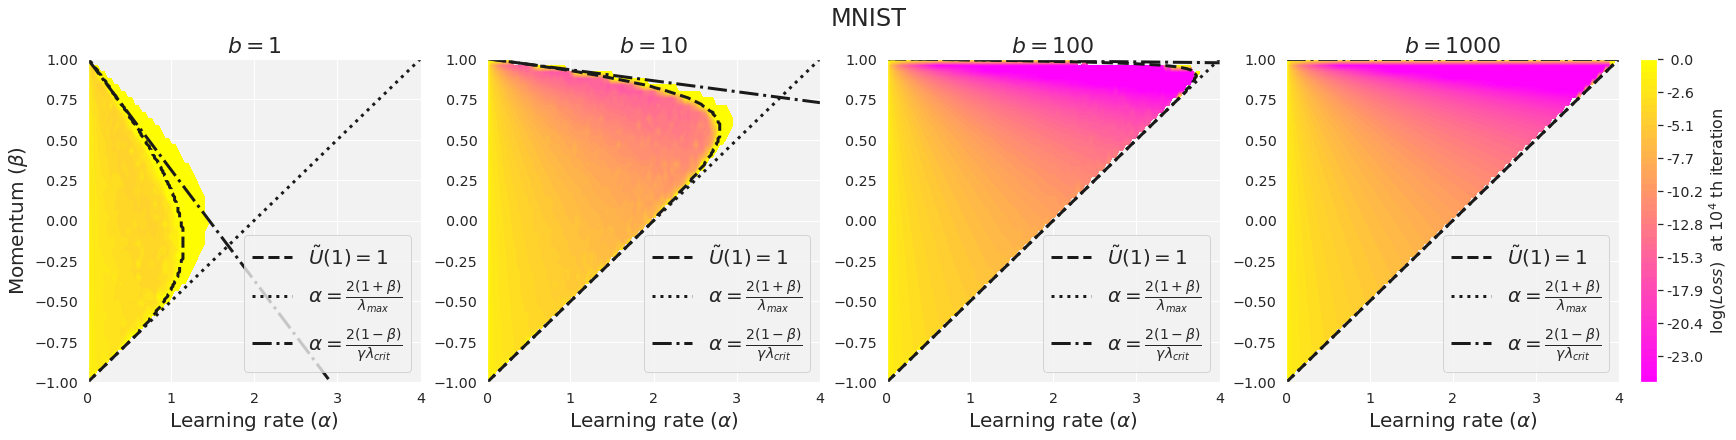

In [29]:
nrows, ncols = len(modes), len(batch_sizes)

fig = plt.figure(constrained_layout=True, figsize=(6 * ncols,  6 * nrows))
# create subfigs
subfigs = fig.subfigures(nrows=len(modes), ncols=1)
if len(modes) == 1:
    subfigs = [subfigs]
# make alphas and betas grid
lrs_grid, momenta_grid = np.meshgrid(alphas, betas)

for i, (mode, subfig) in enumerate(zip(modes, subfigs)):
    # subfig.suptitle(f'{mode}', fontsize=20);
    # make subplots
    ax = subfig.subplots(nrows=1, ncols=len(batch_sizes))
    # plot images
    for j, batch_size in enumerate(batch_sizes):
        last_losses = last_losses_for_batch_size[(mode, batch_size)]
        # clip losses from below
        last_losses = np.clip(last_losses, a_min=np.e ** -25, a_max=1.0)  
        # find critical alpha
        gamma = (N - batch_size) / (N - 1) / batch_size
        if batch_size == N:
            alphas_crit = 2 * (1 + _betas)
        else:
            alphas_crit = _alphas[np.argmax(Us[batch_size].T > 1, axis=1)]
       
        ax[j].plot(alphas_crit, _betas, linestyle='--', linewidth=3, color='k', label=r'$\tilde{U}(1) = 1$')
        # 1st asymptotic
        ax[j].plot(
            _alphas, _betas, 
            linestyle=':',  linewidth=3, color='k', 
            label=r'$\alpha = \frac{2 (1 + \beta)}{\lambda_{max}}$'
        )
        # 2nd asymptotic
        ax[j].plot(
            _alphas, 1 - gamma * _alphas * lambda_crit / 2, 
            linestyle='-.',  linewidth=3, color='k', 
            label=r'$\alpha = \frac{2 (1 - \beta)}{\gamma \lambda_{crit}}$'
        )
    
        im = ax[j].contourf(
            lrs_grid, momenta_grid, 
            np.clip(np.log(last_losses.T), a_min=-25, a_max=0), 
            levels = np.linspace(-25, 0, 50),
            cmap='spring', 
        );
        
        ax[j].set_xlim(-0.0, +4.0);
        ax[j].set_ylim(-1.0, +1.0);

        if i == len(modes) - 1:
            ax[j].set_xlabel(r'Learning rate ($\alpha$)', fontsize=20);
        if j == 0:
            ax[j].set_ylabel(r'Momentum ($\beta$)', fontsize=20);
        ax[j].legend(loc='lower right', fontsize=20);

        if j == len(batch_sizes) - 1:
            cbar = plt.colorbar(im, ax=ax[j], format='% 1.1f');
            cbar.set_label(r'$\log(Loss)$  at $10^4$ th iteration', fontsize=16);
        ax[j].set_title(fr'$b=${batch_size}', fontsize=22);
    
fig.suptitle(fr'MNIST', fontsize=24);
plt.savefig(f'plots/losses_2d/mnist.pdf')

### Negative momentum optimum
---

In [8]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima) 

In [27]:
### training params
N, n_steps = 1000, 10000
batch_sizes = [1, 10]
### Dataset
dataset = 'synthetic'
nu, kappa = 1.5, 3.0
### Modes
modes = ['mean_field']

In [35]:
alphas, betas = None, None
last_losses_for_batch_size = {}

for mode in modes:
    for batch_size in batch_sizes:
        data_path = f'output/{mode}/losses_2d/N=1000/synthetic/nu={nu}/kappa={kappa}/batch_size={batch_size}/loss_curves.pth'
        loss_curves = torch.load(data_path)
        # extract learning rates
        alphas = np.unique([key[1] for key in loss_curves.keys()])
        # extract betas
        betas = np.unique([key[2] for key in loss_curves.keys()])
        # collect last losses
        last_losses = np.zeros((len(alphas), len(betas)))
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                last_losses[i, j] = loss_curves[(batch_size, alpha, beta)][-1]
        last_losses_for_batch_size[(mode, batch_size)] = last_losses

In [37]:
minima_x, minima_y = {}, {}
for mode in modes:
    for batch_size in batch_sizes:
        last_losses = last_losses_for_batch_size[(mode, batch_size)]
        if mode == 'linearized':
            last_losses = filters.gaussian_filter(last_losses, sigma=3.0)
        minimum_x, minimum_y = local_minima(last_losses)
        minima_x[(mode, batch_size)] = minimum_x[-1]
        minima_y[(mode, batch_size)] = minimum_y[-1]

In [38]:
minima_x, minima_y

({('mean_field', 1): 5, ('mean_field', 10): 18},
 {('mean_field', 1): 16, ('mean_field', 10): 21})

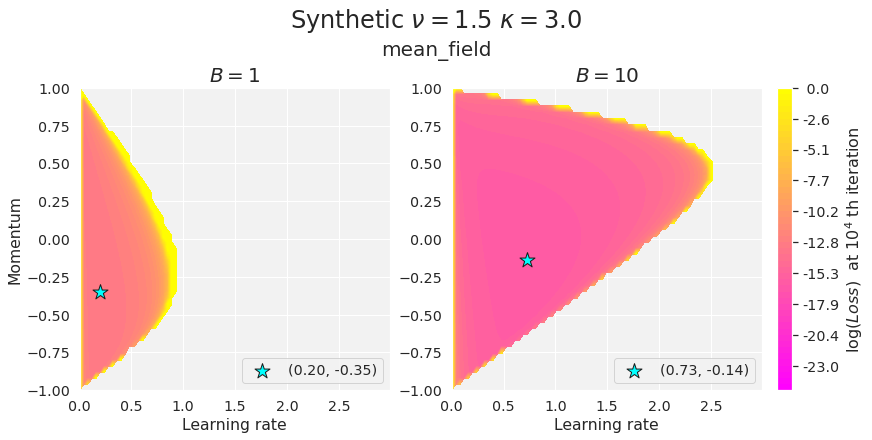

In [43]:
nrows, ncols = len(modes), len(batch_sizes)

fig = plt.figure(constrained_layout=True, figsize=(6 * ncols,  6 * nrows))
# create subfigs
subfigs = fig.subfigures(nrows=len(modes), ncols=1)
# make alphas and betas grid
lrs_grid, momenta_grid = np.meshgrid(alphas[:75], betas)

for i, (mode, subfig) in enumerate(zip(modes, [subfigs])):
    subfig.suptitle(f'{mode}', fontsize=20);
    # make subplots
    ax = subfig.subplots(nrows=1, ncols=len(batch_sizes))
    # plot images
    for j, batch_size in enumerate(batch_sizes):
        last_losses = last_losses_for_batch_size[(mode, batch_size)]
        # clip losses from below
        last_losses = np.clip(last_losses, a_min=np.e ** -25, a_max=1.0) 
         
        im = ax[j].contourf(
            lrs_grid, momenta_grid, 
            np.clip(np.log(last_losses[:75].T), a_min=-25, a_max=0), 
            levels = np.linspace(-25, 0, 50),
            cmap='spring', 
        ); 
        
        minimum_x, minimum_y = minima_x[(mode, batch_size)], minima_y[(mode, batch_size)]
        
        ax[j].scatter(
            alphas[minimum_x], betas[minimum_y], 
            color='cyan', marker='*', s=250, label=f'({alphas[minimum_x]:.2f}, {betas[minimum_y]:.2f})',
            edgecolor='k'
        );

        if i == len(modes) - 1:
            ax[j].set_xlabel(r'Learning rate');
        if j == 0:
            ax[j].set_ylabel(r'Momentum');

        if j == len(batch_sizes) - 1:
            cbar = plt.colorbar(im, ax=ax[j], format='% 1.1f');
            cbar.set_label(r'$\log(Loss)$  at $10^4$ th iteration', fontsize=16);
        ax[j].set_title(fr'$B=${batch_size}', fontsize=20);
        ax[j].legend(loc='lower right');
    
fig.suptitle(fr'Synthetic $\nu=${nu} $\kappa=${kappa}', fontsize=24);
plt.savefig(f'plots/synthetic/losses_2d_negative_momentum.pdf')

### Join MNIST and Synthetic
---


In [9]:
### training params
N, n_steps = 1000, 10000
batch_size = 10
### Modes
modes = ['mean_field', 'linearized']

In [10]:
K, d_f = generate_mnist_ntk_data(size=N, data_root='./data')
# get spectrum and sort in descending order
eigv_mnist = torch.linalg.eigvalsh(K).numpy()[::-1]
# normalize spectrum
eigv_mnist /= eigv_mnist.max()

In [11]:
alphas, betas = None, None
last_losses_mnist = {}

for mode in modes:
    data_path = f'output/{mode}/losses_2d/N=1000/mnist/batch_size={batch_size}/loss_curves.pth'
    loss_curves = torch.load(data_path)
    # extract learning rates
    alphas = np.unique([key[1] for key in loss_curves.keys()])
    # extract betas
    betas = np.unique([key[2] for key in loss_curves.keys()])
    # collect last losses
    last_losses = np.zeros((len(alphas), len(betas)))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            last_losses[i, j] = loss_curves[(batch_size, alpha, beta)][-1]
    last_losses_mnist[mode] = last_losses

In [12]:
_alphas, _betas = np.linspace(0, 4, 200), np.linspace(-1, 1, 200)
gamma = (N - batch_size) / (N - 1) / batch_size
Us_mnist = compute_U(_alphas, _betas, gamma, eigv_mnist)

In [13]:
f = lambda z: effective_dimension(eigv_mnist, z) - 1
lambda_crit_mnist = bisect(f, 1.2, 1.5)

In [14]:
minima_mnist_x, minima_mnist_y = {}, {}
for mode in modes:
    last_losses = last_losses_mnist[mode]
    if mode == 'linearized':
        last_losses = filters.gaussian_filter(last_losses, sigma=2.0)
    minimum_x, minimum_y = local_minima(last_losses)
    minima_mnist_x[(mode)] = minimum_x
    minima_mnist_y[(mode)] = minimum_y

In [15]:
minima_mnist_x, minima_mnist_y

({'mean_field': array([11, 20, 29, 36, 42]),
  'linearized': array([19, 29, 38, 45])},
 {'mean_field': array([48, 47, 46, 45, 44]),
  'linearized': array([39, 38, 37, 36])})

In [16]:
for mode in modes:
    print(mode)
    val_x, val_y = minima_mnist_x[mode], minima_mnist_y[mode] 
    print(f"{val_x}/{val_y} : {last_losses_mnist[mode][val_x, val_y]}")

mean_field
[11 20 29 36 42]/[48 47 46 45 44] : [3.77250409e-08 4.81983840e-08 7.02234999e-08 1.07833394e-07
 1.68563716e-07]
linearized
[19 29 38 45]/[39 38 37 36] : [1.92961321e-04 7.98914334e-05 1.80751395e-05 1.22557676e-05]


In [17]:
minima_mnist_x = {'mean_field': 36, 'linearized': 38}
minima_mnist_y = {'mean_field': 45, 'linearized': 44}

Synthetic 

In [18]:
modes = ['mean_field', 'linearized']

In [19]:
nu, kappa = 1.5, 3.0

In [20]:
eigv_synth = np.arange(1, N + 1) ** (-nu)

In [21]:
alphas, betas = None, None
last_losses_synth = {}

for mode in modes:
    data_path = f'output/{mode}/losses_2d/N=1000/synthetic/nu={nu}/kappa={kappa}/batch_size={batch_size}/loss_curves.pth'
    loss_curves = torch.load(data_path)
    # extract learning rates
    alphas = np.unique([key[1] for key in loss_curves.keys()])
    # extract betas
    betas = np.unique([key[2] for key in loss_curves.keys()])
    # collect last losses
    last_losses = np.zeros((len(alphas), len(betas)))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            last_losses[i, j] = loss_curves[(batch_size, alpha, beta)][-1]
    last_losses_synth[mode] = last_losses

In [22]:
Us_synth = compute_U(_alphas, _betas, gamma, eigv_synth, tau=1)

In [23]:
# def effective_dimension_v2(eigv, z):
#     return np.sum(eigv / (-eigv + z))

In [24]:
f(1.0), f(2.5)

(2.9430317878723145e-01, -0.39382070302963257)

In [25]:
# f = lambda z: effective_dimension_v2(eigv_synth, z) - 1
f = lambda z: effective_dimension(eigv_synth, z) - 1
lambda_crit_synth = bisect(f, 1.0, 2.5)

In [26]:
minima_synth_x, minima_synth_y = {}, {}
for mode in modes:
    last_losses = last_losses_synth[mode]
    if mode == 'linearized':
        last_losses = filters.gaussian_filter(last_losses, sigma=2.0)
    minimum_x, minimum_y = local_minima(last_losses)
    minima_synth_x[(mode)] = minimum_x
    minima_synth_y[(mode)] = minimum_y

In [27]:
minima_synth_x = {'mean_field': 18, 'linearized': 22}
minima_synth_y = {'mean_field': 21, 'linearized': 23}

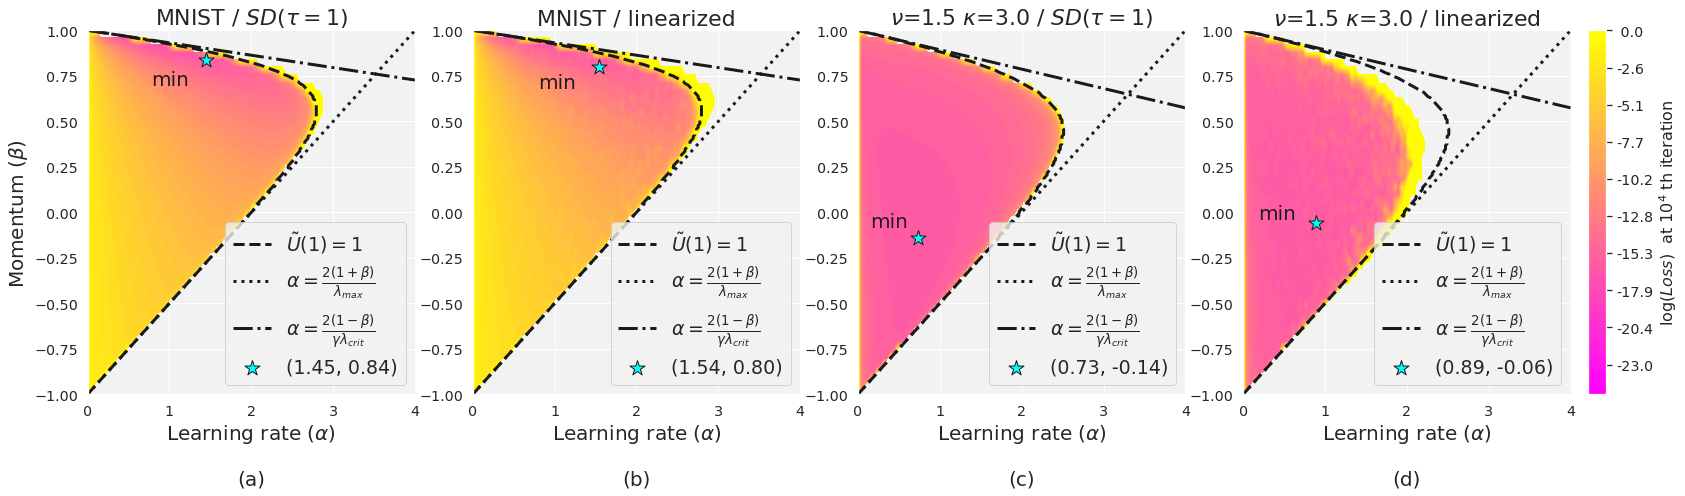

In [28]:
nrows, ncols = 1, 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(6.5 * ncols),  7 * nrows))
# make alphas and betas grid
lrs_grid, momenta_grid = np.meshgrid(alphas, betas)
# letters for plots
letters = ['a', 'b', 'c', 'd']
mode_names = {'mean_field' : r'$SD (\tau=1)$', 'linearized' : 'linearized'}

for i, mode in zip(range(0, 2), modes):
    last_losses = last_losses_mnist[mode]
    # clip losses from below
    last_losses = np.clip(last_losses, a_min=np.e ** -25, a_max=1.0)  
    # find critical alpha
    gamma = (N - batch_size) / (N - 1) / batch_size
    if batch_size == N:
        alphas_crit = 2 * (1 + betas)
    else:
        alphas_crit = _alphas[np.argmax(Us_mnist.T > 1, axis=1)]
    
    ax[i].plot(alphas_crit, _betas, linestyle='--', linewidth=3, color='k', label=r'$\tilde{U}(1) = 1$')
    # 1st asymptotic
    ax[i].plot(
        _alphas, _betas, 
        linestyle=':',  linewidth=3, color='k', 
        label=r'$\alpha = \frac{2 (1 + \beta)}{\lambda_{max}}$'
    )
    # 2nd asymptotic
    ax[i].plot(
        _alphas, 1 - gamma * _alphas * lambda_crit_mnist / 2, 
        linestyle='-.',  linewidth=3, color='k', 
        label=r'$\alpha = \frac{2 (1 - \beta)}{\gamma \lambda_{crit}}$'
    )

    im = ax[i].contourf(
        lrs_grid, momenta_grid, 
        np.clip(np.log(last_losses.T), a_min=-25, a_max=0), 
        levels = np.linspace(-25, 0, 50),
        cmap='spring', 
    );
    
    # plot minimum
    minimum_x, minimum_y = minima_mnist_x[mode], minima_mnist_y[mode]
    ax[i].scatter(
        alphas[minimum_x], betas[minimum_y], 
        color='cyan', marker='*', s=250, label=f'({alphas[minimum_x]:.2f}, {betas[minimum_y]:.2f})',
        edgecolor='k'
    );
    ax[i].text(minimum_x / len(alphas) + 0.65, minimum_y / len(betas) - 0.2, 'min', ha='center', color='k', fontsize=20);

    ax[i].set_xlabel(r'Learning rate ($\alpha$)' + f'\n\n({letters[i]})', fontsize=20);
    if i == 0:
        ax[i].set_ylabel(r'Momentum ($\beta$)', fontsize=20);
    ax[i].legend(loc='lower right', fontsize=19);
    ax[i].set_title(f'MNIST / {mode_names[mode]}', fontsize=22);
    
    
for i, mode in zip(range(2, 4), modes):
    last_losses = last_losses_synth[mode]
    # clip losses from below
    last_losses = np.clip(last_losses, a_min=np.e ** -25, a_max=1.0)  
    # find critical alpha
    gamma = (N - batch_size) / (N - 1) / batch_size
    if batch_size == N:
        alphas_crit = 2 * (1 + betas)
    else:
        alphas_crit = _alphas[np.argmax(Us_synth.T > 1, axis=1)]
    
    ax[i].plot(alphas_crit, _betas, linestyle='--', linewidth=3, color='k', label=r'$\tilde{U}(1) = 1$')
    # 1st asymptotic
    ax[i].plot(
        _alphas, _betas, 
        linestyle=':',  linewidth=3, color='k', 
        label=r'$\alpha = \frac{2 (1 + \beta)}{\lambda_{max}}$'
    )
    # 2nd asymptotic
    ax[i].plot(
        _alphas, 1 - gamma * _alphas * lambda_crit_synth / 2, 
        linestyle='-.',  linewidth=3, color='k', 
        label=r'$\alpha = \frac{2 (1 - \beta)}{\gamma \lambda_{crit}}$'
    )
    
    im = ax[i].contourf(
        lrs_grid, momenta_grid, 
        np.clip(np.log(last_losses.T), a_min=-25, a_max=0), 
        levels = np.linspace(-25, 0, 50),
        cmap='spring', 
    );
    
    # plot minimum
    minimum_x, minimum_y = minima_synth_x[mode], minima_synth_y[mode]
    ax[i].scatter(
        alphas[minimum_x], betas[minimum_y], 
        color='cyan', marker='*', s=250, label=f'({alphas[minimum_x]:.2f}, {betas[minimum_y]:.2f})',
        edgecolor='k'
    );
    ax[i].text(minimum_x / len(alphas) + 0.2, minimum_y / len(betas) - 0.5, 'min', ha='center', color='k', fontsize=20);

    ax[i].set_xlabel(r'Learning rate ($\alpha$)' + f'\n\n({letters[i]})', fontsize=20);
    if i == 0:
        ax[i].set_ylabel(r'Momentum ($\beta$)', fontsize=20);
    ax[i].legend(loc='lower right', fontsize=19);
    ax[i].set_title(rf'$\nu$={nu:.1f} $\varkappa$={kappa:.1f} / {mode_names[mode]}', fontsize=22);
    
fig.tight_layout()
# leave place for cbar
cbar = plt.colorbar(im, ax=ax.ravel().tolist(), format='% 1.1f', pad=0.01);
cbar.set_label(r'$\log(Loss)$  at $10^4$ th iteration', fontsize=16);
        
# plt.savefig(f'plots/mnist_and_synth_losses_2d.pdf')